# Bayesian Demand Estimation for San Francisco Bike Share 

### Samuel Sharpe & Nihaar Shah

 Bike share systems present multiple problems that are uniquely suited to bayesian methods. Bike share systems must have a good understanding of customers in order to properly set up new bike stations, decide station bike capacities, and implement strategies to replenish stations when empty. While there are many elements of customer tendencies that can inform these decisions, we decided to focus on the largest driver, bike demand. Bayesian methods provide more information than maximum likelihood estimates of demand for bike share decision making. For example, if we want to rebalance bikes for a certain station, a bayesian demand estimate can tell us how likely it is that a station will run out of bikes in the next 3 hours (with a simple assumption of 0 supply). We approach demand estimation with various types of bayesian regression.

In [1]:
import pickle
import sys
sys.path.insert(0,'../src/')

import baseline
import zipreg 
import zipgate_reg
import negbin
import negbin_weather_new as negbin_weather
import negbin_reg
from inference import *
from criticism import *
from preprocess_bikeshare import *

# %load_ext autoreload
# %autoreload 2

In [2]:
#Set some plot params
import matplotlib.pyplot as plt
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [3]:
# Set to true for fast run of notebook
QUICK_RUN = False

if QUICK_RUN:
    iters = 3000
    model_param_suffix = '_quick'
    with open('../data/final_train_small.pickle', 'rb') as f:
        train=pickle.load(f)
    with open('../data/final_test_small.pickle', 'rb') as f:
        test=pickle.load(f)
else:
    iters = 9000
    model_param_suffix =''
    with open('../data/final_train.pickle', 'rb') as f:
        train=pickle.load(f)
    with open('../data/final_test.pickle', 'rb') as f:
        test=pickle.load(f)
        
stations = pd.read_csv('../data/stations.csv')


In [4]:
# with open('../data/final_train_small.pickle','wb') as f:
#     pickle.dump(train.groupby(['start_station_id', 'hour']).apply(lambda x: x.sample(5)).reset_index(drop=True),f)
# with open('../data/final_test_small.pickle','wb') as f:
#     pickle.dump(test.groupby(['start_station_id', 'hour']).apply(lambda x: x.sample(5)).reset_index(drop=True),f)

## Data

Our [data](https://www.kaggle.com/benhamner/sf-bay-area-bike-share) ranges over 2 years and includes approximately 670,000 trips taken over that time period. First, a look at some of the basic trends shows us a wide variety of demand at each station and cyclic demand patterns throughout the day on the week and weekend. Included along with this data is information about the stations themselves (number of bike racks) as well as daily weather data. We aggregated this data into 3 hour chunks to make
inference a little quicker and realizing we didn't need the granularity that 1 hour chunks provided. 

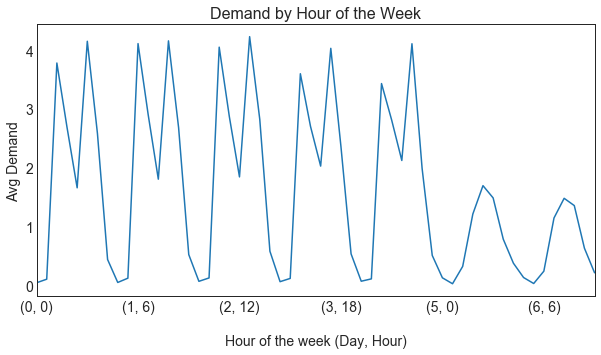

In [5]:
train.groupby(['weekday','hour'])['demand'].mean().plot.line(figsize = (10,5))
plt.xlabel('\nHour of the week (Day, Hour)')
plt.ylabel('Avg Demand')
plt.title('Demand by Hour of the Week', fontsize=16)
plt.show()

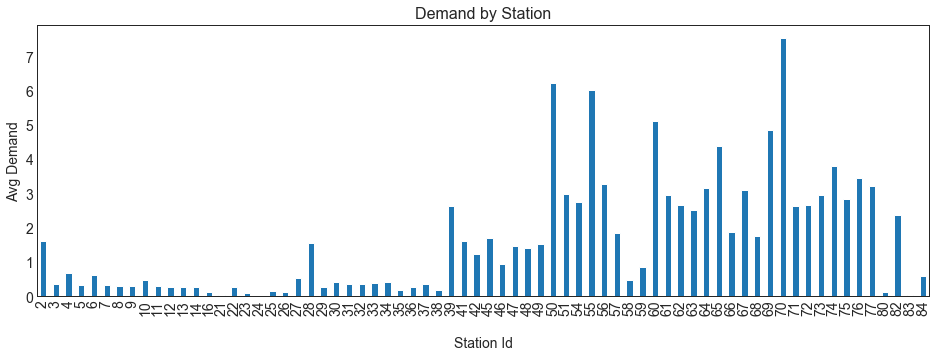

In [17]:
train.groupby(['start_station_id'])['demand'].mean().plot.bar(figsize = (16,5))
plt.xlabel('\nStation Id')
plt.ylabel('Avg Demand')
plt.title('Demand by Station', fontsize=16)
plt.show()

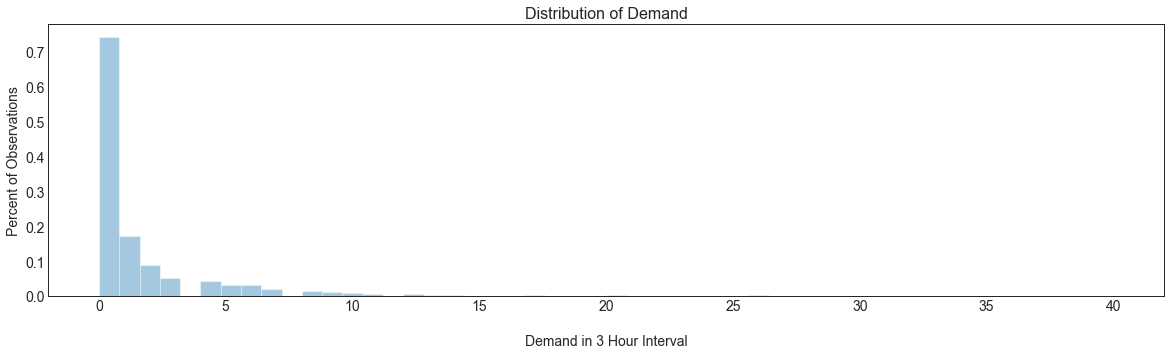

count    2800.00
mean        1.63
std         3.39
min         0.00
50%         0.00
70%         1.00
80%         2.00
90%         5.00
95%         8.00
99%        16.00
max        40.00
Name: demand, dtype: float64


In [8]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(20,5))
plt.figure(figsize=(20,5))
sns.distplot(train['demand'],norm_hist=True, kde = False)
plt.xlabel('\nDemand in 3 Hour Interval')
plt.ylabel('Percent of Observations')
plt.title('Distribution of Demand', fontsize=16)
plt.show()
print(train['demand'].describe(percentiles=[.5,.7,.8,.9,.95,.99]).round(2))

## Model 1: Model Formulation (Poisson)

We thought a regression would be a sound way to model the data rather than timeseries based methods. We are trying to 
model demand uncertainty based off various factors. A regression can capture a large portion of this information given our patterns are largely cyclical. We decided to first apply Poisson regression. Though the distribution above suggests that Poisson may not be the best fit, it is a good starting point for modeling count data. 

We started with some simple assumptions that our rate of arrivals depend on two latent arrival components for stations and time:

$$\text{station s} = \mu_s$$
$$\text{time (weekday w, hour h)} = \mu_{w,h} $$
$$w \in \{\text{weekday, weekend}\}, h \in \{0,3,6,9,12,15,18,21\}$$

Our priors on our latent components are simply:

$$\mu_s, \mu_{w,h} \sim \mathcal{N}(0,1)$$

We assume for this model that demand observation $i$ at a station $s$ and time $w,h$ follow a Poisson distribution:

$$d_{i,s,w,h} \sim Pois(\lambda_{s,w,h})$$

$$\lambda_{s,w,h} = \exp\{\mu_s+\mu_{w,h} \}$$

Let $M_{s,w,h}$ be the number of observations at a station $s$ and time $w,h$.We can write the joint probability for this model as

$$p(d,\mu_s,\mu_{w,h}) = \prod_{s \in S}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_s^2}{2}}\prod_{w \in W}\prod_{h \in H}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_{w,h}^2}{2}}\prod_{i = 1}^{M_{s,w,h}} \frac{e^{d_{i, s,w,h}(\mu_s+\mu_{w,h})}e^{-\mu_s-\mu_{w,h}}}{d_{i, s,w,h}!}$$

## Model 1: Inference

In [7]:
b_data, b_features = baseline.feature_generation(train)
b_data_test, _ = baseline.feature_generation(test)
b = baseline.PoissReg(b_features, b_data)

In [10]:
#Perform SVI
svi_baseline, elbo_loss = run_svi(b.model, b.guide,
                                 iters=iters,
                                 data=b_data['data'],
                                 demand=b_data['demand'],
                                 filename=f'../models/svi_baseline_params{model_param_suffix}.pkl')

svi_posterior_baseline = get_svi_posterior(b_data['data'], b_data['demand'],
                                          svi=svi_baseline)

#plot_elbo(elbo_loss[3000:])

../src/baseline.py:86: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  with pyro.plate("data", len(data)):
Elbo loss: 1220401.25
Elbo loss: 315753.84375
Elbo loss: 251097.21875
Elbo loss: 242388.578125
Elbo loss: 239330.578125
Elbo loss: 235620.515625
Elbo loss: 234083.8125
Elbo loss: 233829.859375
Elbo loss: 233210.59375


In [11]:
# # Load parameters from inference
# svi_posterior_baseline = get_svi_posterior(b_data['data'], b_data['demand'],
#                                     model = b.model,
#                                   guide = b.guide,
#                                   filename='../models/svi_baseline_params.pkl')


## Model 1: Criticism

In [12]:
print(f"WAIC: {float(svi_posterior_baseline.information_criterion()['waic'].detach().numpy())}")


WAIC: 467777.78125


In [13]:
post_samples_base = ppd_samples(
    b.wrapped_model,
    svi_posterior_baseline,
    b_data_test,
    ['obs'],
    num_samples=1000).squeeze()

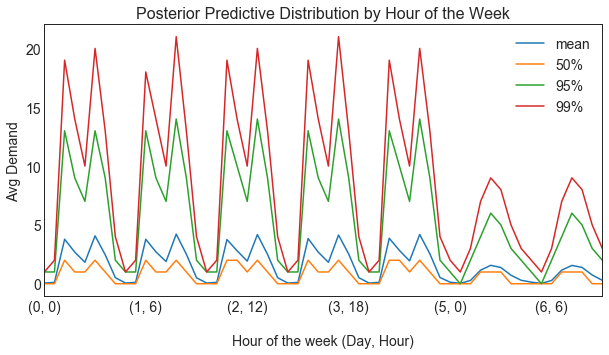

In [55]:
post_combined = align_regressors_ppd(test, post_samples_base)
post_combined.groupby(['weekday','hour'])['value'].describe(percentiles = [.5,.95,.99])[['mean','50%','95%','99%']].plot(figsize = (10,5))
plt.xlabel('\nHour of the week (Day, Hour)')
plt.ylabel('Avg Demand')
plt.title('Posterior Predictive Distribution by Hour of the Week', fontsize=16)
plt.show()

We can see with some simple checks of the posterior predictive distribution (PPD) that a Poisson distribution may not be the best assumption. We underestimate the number of demand observations with no bikes taken off the rack. 

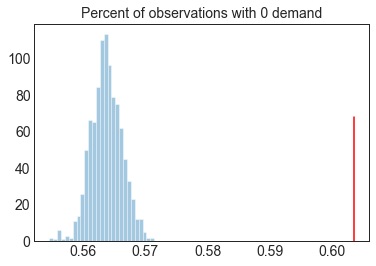

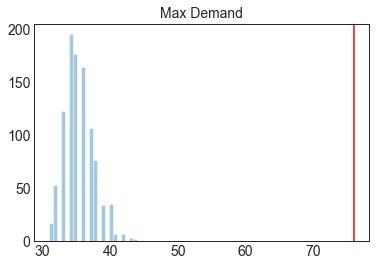

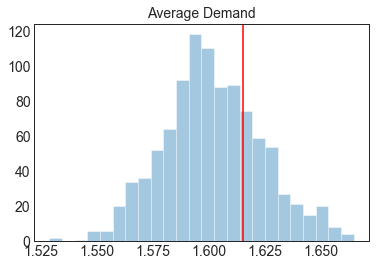

In [15]:
compare_test_statistic(test.demand.values, post_samples_base,
                       stat=perc_0, title = 'Percent of observations with 0 demand')
compare_test_statistic(test.demand.values, post_samples_base,
                       stat=max_, title = 'Max Demand')
compare_test_statistic(test.demand.values, post_samples_base, stat=mean, title = 'Average Demand')


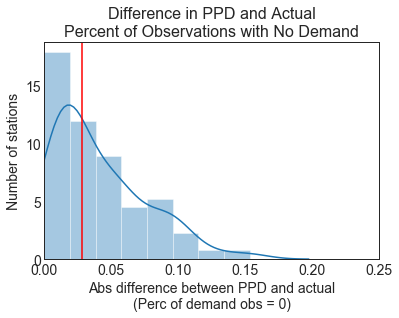

In [57]:
baseline_perc0_compare = stat_by_station(test, post_combined, stat = perc_0)
sns.distplot(baseline_perc0_compare['diff'])
plt.axvline(x=baseline_perc0_compare['diff'].median(), color='red', linestyle='-')
plt.xlim((0,.25))
plt.xlabel('Abs difference between PPD and actual\n(Perc of demand obs = 0)')
plt.ylabel('Number of stations')
plt.title('Difference in PPD and Actual\nPercent of Observations with No Demand', fontsize=16)
plt.show()


## Reconsidering Distribution Assumptions

We can model the average rate with a Poisson assumption well, but the  $Var[D]$ is restricted to be equal to $E[D]$. The demand distribution is overdispersed as seen by the average and variance below. Since we underestimate the percentage of time periods with no demand, a Zero Inflated Poisson (ZIP) may be a better assumption. ZIP will allow the distribution to vary a bit more and keep some mass on 0.

In [58]:
#Overdispersed 
print(f'Demand mean: {train["demand"].mean().round(3)}')
print(f'Demand var: {train["demand"].var().round(3)}')
      

Demand mean: 1.602
Demand var: 12.85


In [59]:
# Distribution of overdispersion (Var(x)/E[x]) by station and time
m_v = train.groupby(['start_station_id','weekday','hour'])['demand'].agg(['mean','var'])
(m_v['var']/m_v['mean']).describe()


count    3429.000000
mean        1.424208
std         0.715311
min         0.260000
25%         1.000000
50%         1.238226
75%         1.627907
max        10.666206
dtype: float64

# Model 2: Model Formulation (Zero Inflated Poisson)

Now we assume that demand follows a Zero Inflated Poisson distribution (ZIP) which can be thought of as a mixture of a poisson and bernoulli. 

$$p(k) = (1-\rho)\frac{\lambda^k e^{-\lambda}}{k!} + \rho {1}_{k=0}$$



We keep the same priors on our station and time latent factors. 

We assume that we have one global $\rho$ where
$$\rho \sim Beta(\alpha, \beta)$$ 

and we impose another level of priors encoding an initial belief that $\rho<.5$:
$$\alpha \sim Gamma(2,2)$$
$$\beta \sim Gamma(3,2)$$

Again, our assumtion on demand:

$$d_{i,s,w,h} \sim ZIP(\rho,\lambda_{s,w,h})$$

$$\lambda_{s,w,h} = \exp\{\mu_s+\mu_{w,h} \}$$

Our new joint probability for this model is:
$$p(\rho,\alpha, \beta) = \frac{2^2}{\Gamma(2)}\alpha e^{-2\alpha}\frac{2^3}{\Gamma(3)}\beta e^{-2\beta}\frac{1}{B(\alpha, \beta)}\rho^{\alpha-1}(1-\rho)^{\beta-1}$$

$$p(d,\mu_s,\mu_{w,h},\rho) = p(\rho,\alpha, \beta) \prod_{s \in S}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_s^2}{2}}\prod_{w \in W}\prod_{h \in H}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_{w,h}^2}{2}}\prod_{i = 1}^{M_{s,w,h}} \left[(1-\rho)\frac{e^{d_{i, s,w,h}(\mu_s+\mu_{w,h})}e^{-\mu_s-\mu_{w,h}}}{d_{i, s,w,h}!}+ \rho1_{d_{i, s,w,h}=0}\right]$$

In [60]:
z_data, z_features = zipreg.feature_generation(train)
z_data_test,_ = zipreg.feature_generation(test)
z = zipreg.ZIPoissReg(z_features, z_data)


In [77]:
# Perform SVI
svi_zip, elbo_loss = run_svi(z.model, z.guide,
                                 iters=iters,
                                 data=z_data['data'],
                                 demand=z_data['demand'],
                                 filename=f'../models/svi_zip_params{model_param_suffix}.pkl')

svi_posterior_zip = get_svi_posterior(z_data['data'], z_data['demand'],
                                          svi=svi_zip)

#plot_elbo(elbo_loss[3000:])


In [ ]:
# svi_posterior_zip = get_svi_posterior(z_data['data'], z_data['demand'],
#                                 model = z.model,
#                                   guide = z.guide,
#                                   filename=f'../models/svi_zip_params{model_param_suffix}.pkl')


In [64]:
print(f"WAIC: {float(svi_posterior_zip.information_criterion()['waic'].detach().numpy())}")
      

WAIC: 458365.84375


In [65]:
post_samples_zip = ppd_samples(
    z.wrapped_model,
    svi_posterior_zip,
    z_data_test,
    ['obs'],
    num_samples=1000).squeeze()

In [66]:
post_combined_zip = align_regressors_ppd(test, post_samples_zip)


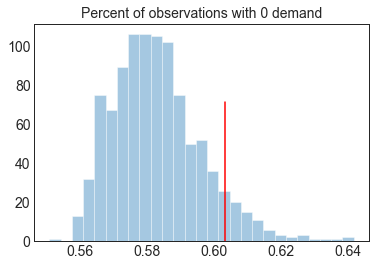

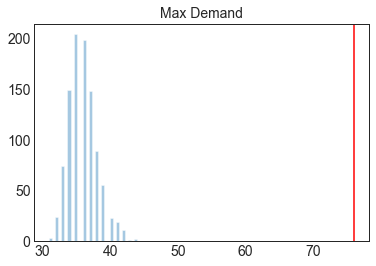

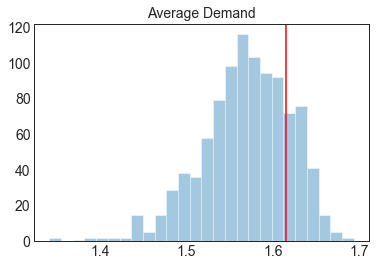

In [67]:
compare_test_statistic(test.demand.values, post_samples_zip,
                       stat=perc_0, title = 'Percent of observations with 0 demand')
compare_test_statistic(test.demand.values, post_samples_zip,
                       stat=max_, title = 'Max Demand')
compare_test_statistic(test.demand.values, post_samples_zip, stat=mean, title = 'Average Demand')

In [49]:

# zip_perc0_compare = stat_by_station(test, post_combined_zip, stat = perc_0)
# sns.distplot(zip_perc0_compare['diff'])
# plt.axvline(x=zip_perc0_compare['diff'].median(), color='red', linestyle='-')
# plt.xlim((0,.25))
# plt.xlabel('Abs difference between PPD and actual\n(Perc of demand obs = 0)')
# plt.ylabel('Number of stations')
# plt.title('Percent of Observations with No Demand: Abs Difference By Station (Actual vs PPD)', fontsize=16)
# plt.show()

## Model 3: Model Formulation (Negative Binomial)

Our poserior predictive check on the max of the distribution did not come close to reaching the actual test data, we posit that our model needs more flexibility with its variance $Var[D]$.

$Y \sim NB(r,p)$ which has the probability density function:
$$ p(Y=d |(r,p)) = {(d+r-1) \choose (d)} (1-p)^r p^d  =\frac{\Gamma(k+r)}{k!\Gamma(r)}(1-p)^r p^d $$


$$r \sim Gamma(1,1) \therefore Pr(r) = \frac{1}{\Gamma(1)} exp(-r)$$

We place the same normal priors on $\mu$:
$$\mu_{h,d}, \mu_{s}\sim N(0,1)$$

Our joint model is then:


$$Pr(d,r,\mu_s,\mu_{w,h}) =  Pr(r) \prod_{s \in S} Pr(\mu_s) \prod_{w \in W}\prod_{h \in H} Pr(\mu_{w,h}) \prod_{i=1}^{M_{s,w,h}} Pr(d_{i, s,w,h}|(r,\mu_s,\mu_{w,h}))$$

Let $p_{i, s,w,h} = \sigma(\mu_s+\mu_{w,h})$

$$Pr(d,r,\mu_s,\mu_{w,h}) = \frac{e^{-r}}{\Gamma(1)}\prod_{s \in S}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_s^2}{2}}\prod_{w \in W}\prod_{h \in H}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_{w,h}^2}{2}}\prod_{i = 1}^{M_{s,w,h}} \frac{\Gamma(d_{i, s,w,h}+r)}{d_{i, s,w,h}!\Gamma(r)}(1-p_{i, s,w,h})^r p_{i, s,w,h}^{d_{i, s,w,h}}$$

In [70]:
nb_data, nb_features = negbin.feature_generation(train)
nb_data_test, _ = negbin.feature_generation(test)
nb = negbin.NegBinReg(nb_features, nb_data)


In [78]:
# Perform SVI
svi_negbin, elbo_loss = run_svi(nb.model, nb.guide,
                                 iters=iters,
                                 data=nb_data['data'],
                                 demand=nb_data['demand'],
                                 filename=f'../models/svi_negbin_params{model_param_suffix}.pkl')

svi_posterior_negbin = get_svi_posterior(nb_data['data'], nb_data['demand'],
                                          svi=svi_negbin)

#plot_elbo(elbo_loss[3000:])


In [7]:
# # Load parameters from inference
# svi_posterior_negbin = get_svi_posterior(nb_data['data'], nb_data['demand'],
#                                     model = nb.model,
#                                   guide = nb.guide,
#                                   filename='../models/svi_negbin_params.pkl')


In [72]:
print(f"WAIC: {float(svi_posterior_negbin.information_criterion()['waic'].detach().numpy())}")
      

WAIC: 426515.0


In [73]:
post_samples_negbin= ppd_samples(
    nb.wrapped_model,
    svi_posterior_negbin,
    nb_data_test,
    ['obs'],
    num_samples=1000).squeeze()


In [74]:
# Align regressors with ppd
post_combined_negbin = align_regressors_ppd(test, post_samples_negbin)


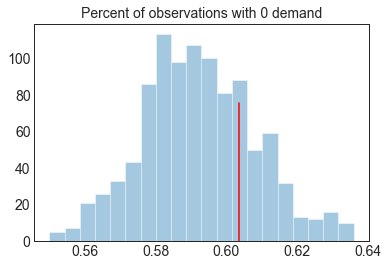

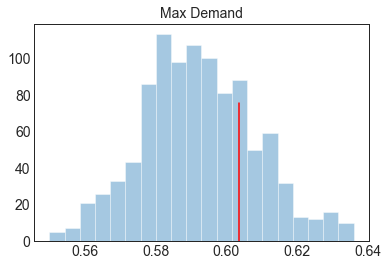

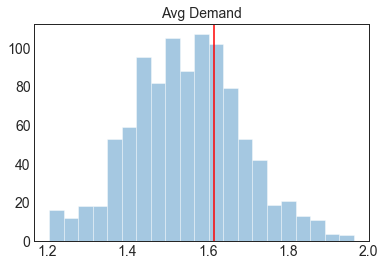

In [75]:
compare_test_statistic(test.demand.values, post_samples_negbin,
                       stat=perc_0, title = 'Percent of observations with 0 demand')
compare_test_statistic(test.demand.values, post_samples_negbin,
                       stat=perc_0, title = 'Max Demand')
compare_test_statistic(test.demand.values, post_samples_negbin,
                       stat=mean, title = 'Avg Demand')


In [64]:
# post_combined_negbin = align_regressors_ppd(test, post_samples_negbin)
# zip_max_compare = stat_by_station(test, post_combined_zip, stat = max_)
# negbin_max_compare = stat_by_station(test, post_combined_negbin, stat = max_)
# sns.distplot(negbin_max_compare['diff'])
# #plt.xlim((0,.25))
# plt.xlabel('Abs difference between PPD and actual\n(Perc of demand obs = 0)')
# plt.ylabel('Number of stations')
# plt.title('Percent of Observations with No Demand: Abs Difference By Station (Actual vs PPD)', fontsize=16)
# plt.show()

## Model 4: Model Formulation 

We now introduce weather into our negative binomial formulation. We assign similar priors to the coeficients on weather. 

$$\beta_{t}, \beta_{p} \sim N(0,1) \therefore Pr(\beta_{i}) = N(0,1) = \frac{1}{\sqrt{2\pi}}exp(\frac{-(\beta_{i})^2}{2})$$

Our joint model is then:


Let $p_{i, s,w,h} = \sigma(\mu_s+\mu_{w,h}+\beta_{t}*Temp_{i, s,w,h}+\beta_{p}*Precip_{i, s,w,h})$

$$Pr(d,r,\mu_s,\mu_{w,h},\beta_{t},\beta_{p}) = \frac{e^{-r}}{\Gamma(1)}\frac{1}{2\pi}e^{\frac{-\beta_t^2-\beta_p^2}{2}}\prod_{s \in S}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_s^2}{2}}\prod_{w \in W}\prod_{h \in H}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_{w,h}^2}{2}}\prod_{i = 1}^{M_{s,w,h}} \frac{\Gamma(d_{i, s,w,h}+r)}{d_{i, s,w,h}!\Gamma(r)}(1-p_{i, s,w,h})^r p_{i, s,w,h}^{d_{i, s,w,h}}$$

### NegBinomial w/ Weather

In [4]:
nbw_data, nbw_features = negbin_weather.feature_generation(train.copy())
nbw_data_test, _ = negbin_weather.feature_generation(test.copy())
nbw = negbin_weather.NegBinReg(nbw_features, nbw_data)

In [5]:
# Perform SVI
svi_negbin_weather, elbo_loss = run_svi(nbw.model, nbw.guide,
                                 iters=2000,
                                 data=nbw_data['data'],
                                 demand=nbw_data['demand'],
                                 filename=f'../models/svi_negbin_weather_params{model_param_suffix}.pkl')

svi_posterior_negbin_weather = get_svi_posterior(nbw_data['data'], nbw_data['demand'],svi=svi_negbin_weather)

#plot_elbo(elbo_loss[3000:])

../src/negbin_weather_new.py:169: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  total_count_loc = pyro.param('total_count_loc', torch.tensor(5.),
../src/negbin_weather_new.py:225: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  0.25)))
../src/negbin_weather_new.py:137: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that

In [6]:
print(f"WAIC: {float(svi_posterior_negbin_weather.information_criterion()['waic'].detach().numpy())}")

WAIC: 456583.21875


In [18]:
post_samples_negbin_weather= ppd_samples(
    nbw.wrapped_model,
    svi_posterior_negbin_weather,
    nbw_data_test,
    ['obs'],
    num_samples=1000).squeeze()

In [8]:
site_post = posterior_site_samples(
        svi_posterior_negbin_weather,
        ['mean_temp', 'mean_temp_squared'])

In [9]:
pd.DataFrame(site_post).describe()

,mean_temp,mean_temp_squared
count,1000.000000,1000.000000
mean,-0.776752,0.435025
std,0.218916,0.311609
min,-1.540714,-0.751788
25%,-0.914217,0.222345
50%,-0.782395,0.439985
75%,-0.631979,0.642272
max,-0.126894,1.492566


In [80]:
# train['temp_bucket'] = pd.cut(train.mean_temperature_f/120,bins = 10)

In [81]:
# train.groupby('temp_bucket')['demand'].mean().plot()

In [50]:
post_combined_negbin_w = align_regressors_ppd(test, post_samples_negbin_weather)

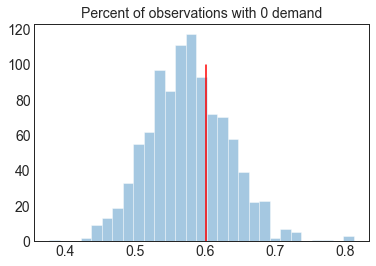

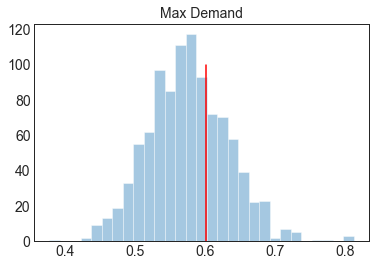

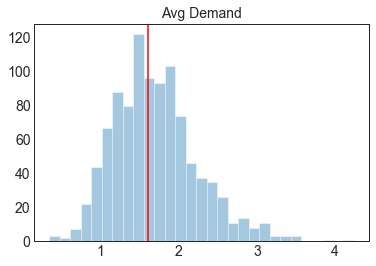

In [51]:
compare_test_statistic(test.demand.values, post_samples_negbin_weather,
                       stat=perc_0, title = 'Percent of observations with 0 demand')
compare_test_statistic(test.demand.values, post_samples_negbin_weather,
                       stat=perc_0, title = 'Max Demand')
compare_test_statistic(test.demand.values, post_samples_negbin_weather,
                       stat=mean, title = 'Avg Demand')

In [ ]:
funs = [mean, perc_0, var, max_, p80]

In [71]:
from functools import  partial
p80 = partial(percentile, q = 80)
p90 = partial(percentile, q = 90)
p95 = partial(percentile, q = 95)
funs = [mean, perc_0, var, max_, p80, p90, p95]
labels =['mean','perc_0','var','max','p80','p90', 'p95']
models = [post_combined_zip, post_combined_negbin, post_combined_negbin_weather]

compare_dict = {}
for i in range(len(funs)):
    compare_dict[labels[i]] = []
    for m in models:
        compare_dict[labels[i]].append(stat_by_station(test, m, stat = funs[i])['diff'].mean())

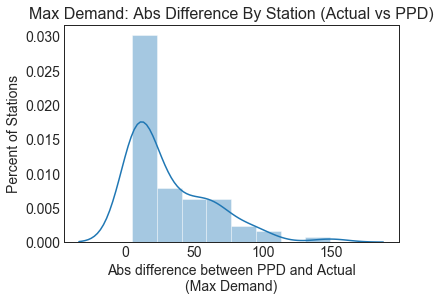

In [27]:
post_combined_negbin_weather = align_regressors_ppd(test, post_samples_negbin_weather)
negbin_weather_max_compare = stat_by_station(test, post_combined_negbin_weather, stat = max_)
sns.distplot(negbin_weather_max_compare['diff'])
plt.xlabel('Abs difference between PPD and Actual\n(Max Demand)')
plt.ylabel('Percent of Stations')
plt.title('Max Demand: Abs Difference By Station (Actual vs PPD)', fontsize=16)
plt.show()